First, we produce a baseline HR diagram. This has since been implemented in HR.py. 
Then we compare with another cluster and shift to get distance estimate AND uncertainty.

In [1]:
"""
# run only if needed
%pip install numpy
%pip install pandas
%pip install matplotlib
"""

'\n# run only if needed\n%pip install numpy\n%pip install pandas\n%pip install matplotlib\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import HR 
import os 
warnings.filterwarnings('ignore')

dir_path = os.path.abspath('')
DPI_SCALE = 2


# import data from calibrated stars text file
calStars = pd.read_csv('..\Data\Camera Images\calibrated star data.txt',delimiter=' ')
import os
print(os.getcwd())

calStarNames = calStars['Name']

c:\University\PHYS3080\Project_Distance-Ladder\HR_Diagram


To set up the color-color diagram, we first want to set up a magnitude system. In our universe, apparent magnitudes are given by $$m_1 - m_0 = -2.5 \log \frac{I_1}{I_0},$$ for reference magnitude and intensity $m_0,I_0$. I will choose to ignore the scaling factor $-2.5$ and the rescaling, so that we have apparent magnitude $$ m = \log I.$$

First, we filter for parallaxes $>$ parallaxLimit (tentatively 0.01).

In [3]:
parallaxLimit = 0.01

# define function to convert from apparent to absolute magnitude.
def fluxToApp(flux):
    return -np.log(flux)

def appToAbs(m,d):
    return m - 2*np.log(d) 

filtStars = calStars.loc[calStars['Parallax'] > parallaxLimit]
filtStarNames = np.array(filtStars['Name']) # names for identification
filtStarBlue = np.array(filtStars['BlueFlux']) # blue flux
filtStarGreen = np.array(filtStars['GreenFlux']) # green flux
filtStarRed = np.array(filtStars['RedFlux']) # red flux
filtStarDists = np.array(filtStars['Distance']) # distances
filtStarPer = np.array(filtStars['Periodicity']) # periods

filtStarColor = fluxToApp(filtStarBlue) - fluxToApp(filtStarRed)

filtStarGreenAMags = appToAbs(fluxToApp(filtStarGreen), filtStarDists)


The following tells us how many stars have been excluded by the condition that parallax $>$ parallaxLimit, for comparison's sake.

In [4]:
print(len(calStarNames))
print(len(filtStarNames))

871
246


We now plot and save the HR diagram.

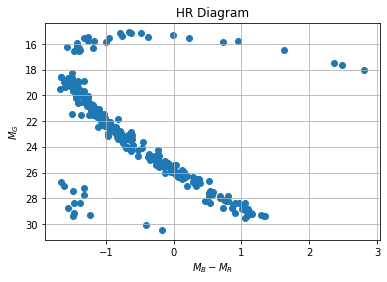

In [5]:
fig, ax = plt.subplots(1,1)
ax.scatter(filtStarColor, filtStarGreenAMags)

ax.set_title('HR Diagram')
ax.set_ylabel('$M_G$')
ax.set_xlabel('$M_B - M_R$')
ax.invert_yaxis()
ax.grid()

fig.show()


From here we will use the HR.py implementation, which looks as follows:

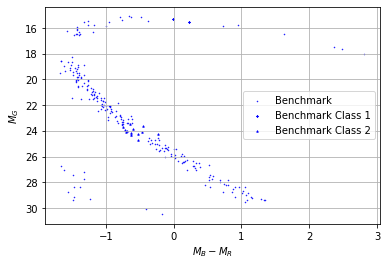

In [6]:
fig, ax = HR.plotBaseline()
ax.legend()
fig.show()

The code has since been updated to include periodicity classes. Class 1 have low periods, class 2 have high periods.

Our next goal is to plot against this figure another star cluster and find the distance.
The following has been written after clusterDistances.py so I will be copying code from there.

X162.5-Y62.0-N111


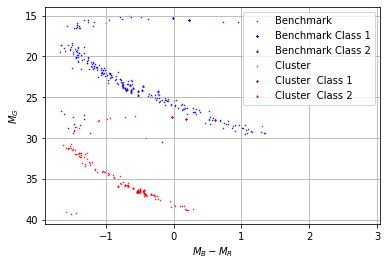

In [7]:
# get baseline to plot against
fig, ax = HR.plotBaseline()

# get list of all clusters
cluster_dir = "../Data/Camera Images/Star Clusters/"

starClusters = pd.read_csv('clusterDistances.csv')
clusterName = list(starClusters['ClusterName'])[5]

# pick a nice cluster, I choose row index 5
clusterData = pd.read_csv(cluster_dir + '/' + clusterName + '.txt', delimiter=' ')

clusterRed = np.array(clusterData['RedFlux'])
clusterBlu = np.array(clusterData['BlueFlux'])
clusterGre = np.array(clusterData['GreenFlux'])
clusterPer = np.array(clusterData['Periodicity'])

# now we plot this cluster, using the HR.py implementation
HR.plotHR(*list(map(lambda x: HR.appToAbs(HR.fluxToApp(x), np.ones(len(x))),
            [clusterRed, clusterGre, clusterBlu])), clusterPer, ax,col='red')
ax.grid()
ax.legend()
fig.show()

# print cluster name for reference!
print(clusterName)
fig.savefig(dir_path + "/distance-modulus-example.png", dpi=DPI_SCALE*100,\
    bbox_inches='tight', pad_inches = 0.01)

This isn't quite what we want, so let's try shifting it all upwards! The distance is currently set to 1, so let's define a function that can take in a distance and a magnitude shift, and output a new distance. 

Eyeballing it, we can see that we need to shift it by about -15 magnitudes.

In [8]:
# taken directly from HR.py 

def distModToDist(m_M):
    return np.exp((m_M)/2)

def distShiftByModulus(d,m):
    # shift a distance in pc given a modulus to shift UP by
    # to be used to make adjustments to HR diagrams
    return distModToDist(2*np.log(d)+m)

distShiftByModulus(1,15)

1808.0424144560632

So our new distance is 1808. Let's try it!

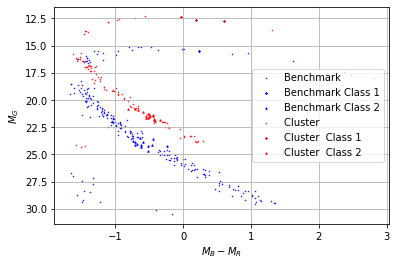

In [9]:
# get baseline to plot against
fig, ax = HR.plotBaseline()

# now we plot this cluster, using the HR.py implementation
HR.plotHR(*list(map(lambda x: HR.appToAbs(HR.fluxToApp(x), 1808.0424144560632),
            [clusterRed, clusterGre, clusterBlu])), clusterPer, ax,col='red')
ax.grid()
ax.legend()
fig.show()

A little bit too high. After some fiddling around, we find a distance of 452.9502466.

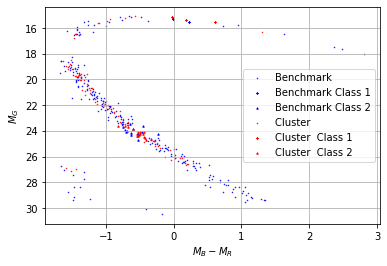

In [10]:
# get baseline to plot against
fig, ax = HR.plotBaseline()

# now we plot this cluster, using the HR.py implementation
HR.plotHR(*list(map(lambda x: HR.appToAbs(HR.fluxToApp(x), 452.9502466),
            [clusterRed, clusterGre, clusterBlu])), clusterPer, ax,col='red')
ax.grid()
ax.legend()
fig.show()

Now we want to estimate uncertainties in this magnitude and hence distance. 
Let's try an uncertainty of 1 magnitude.

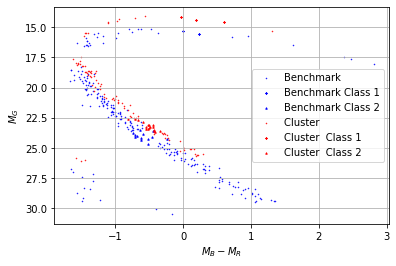

In [11]:
# +1
# get baseline to plot against
fig, ax = HR.plotBaseline()

# now we plot this cluster, using the HR.py implementation
HR.plotHR(*list(map(lambda x: HR.appToAbs(HR.fluxToApp(x), HR.distShiftByModulus(452.9502466,1)),
            [clusterRed, clusterGre, clusterBlu])), clusterPer, ax,col='red')
ax.grid()
ax.legend()
fig.show()

Ok that's a little big too big, try 0.5 

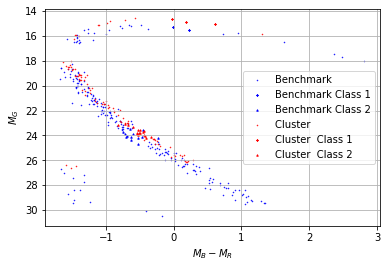

In [12]:
# +0.5
# get baseline to plot against
fig, ax = HR.plotBaseline()

# now we plot this cluster, using the HR.py implementation
HR.plotHR(*list(map(lambda x: HR.appToAbs(HR.fluxToApp(x), HR.distShiftByModulus(452.9502466,0.5)),
            [clusterRed, clusterGre, clusterBlu])), clusterPer, ax,col='red')
ax.grid()
ax.legend()
fig.show()

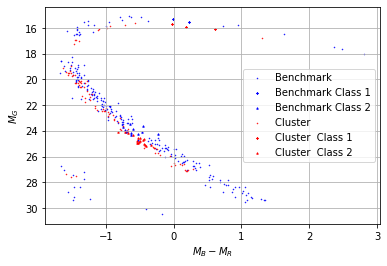

In [13]:
# -0.5
# get baseline to plot against
fig, ax = HR.plotBaseline()

# now we plot this cluster, using the HR.py implementation
HR.plotHR(*list(map(lambda x: HR.appToAbs(HR.fluxToApp(x), HR.distShiftByModulus(452.9502466,-0.5)),
            [clusterRed, clusterGre, clusterBlu])), clusterPer, ax,col='red')
ax.grid()
ax.legend()
fig.show()

This seems pretty reasonable! The corresponding distances are:

In [14]:
print(HR.distShiftByModulus(452.9502466,0.5))
print(HR.distShiftByModulus(452.9502466,-0.5))

581.5996291293801
352.7580067444659


Our estimate is hence
$$
    453_{353}^{582} \text{ pc}.
$$

In relative uncertainty, we have
$$
    452^{+29\%}_{-22 \% } \text{ pc.}
$$

In [15]:
print(HR.distShiftByModulus(1911.5,-0.5))
print(HR.distShiftByModulus(1911.5, 0.5))

1488.67769684099
2454.414583998617


Taking a few other representatives, say X246.6-Y106.5-N96, we have distance estimation
$$
    1911.5_{1488.7}^{2454.4} = 1911.5_{-22\%}^{+28\%} \text{ pc.}
$$

Taking these as representatives, we have uncertainties with a lower bound of $-22\%$ and an upper bound of $+29\%$.